# Building a case for human-induced global warming.

Adam Watt and Seán O'Neill

## Introduction

The aim of this project is to show that the carbon dioxide levels in the atmosphere as a result of human-related activities are causing the average global temperature to rise. We have found evidence, from available data, to support this fact by showing a correlation between temperature anomaly and carbon dioxide and that there is little to no correlation between temperature and other climate-related measurements.

Once this evidence is established, our focus is turned to a predictive model of the temperature anomaly and carbon dioxide level. We develop a simple model based on differential equations, and we calculate the best-fitting parameters using a least-squares optimization algorithm on the sum of squared residuals between the model and the data. Finally, a Bayesian statistical approach is used to fit the model to the data and obtain appropriate 95% credible intervals.

## Preliminaries

In [1]:
# necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import xarray as xr

# data directory
dir = "../data/"

## Establishing a mean global temperature drift.

First, we need to establish a mean global temperature drift, i.e. a yearly temperature change averaged over the Earth's surface. As is typical in the field of climate science, we will work in terms of temperature anomaly, which is the temperature deviation relative to a 30 year average value. In this work, we use the standard 1951-1980 baseline (~14°C).

The temperature data is accessed from the [NASA GISTEMP v4](https://data.giss.nasa.gov/gistemp/) dataset. This dataset contains estimated monthly mean temperature anomalies for the years 1880-2023 on a 2°x2° global grid. Each grid point is a linearly-weighted average of all observed temperature measurements within a 1200km radius. This is the distance where the correlation between measurement stations drops to below 50%.

Pre-processing of the temperature is performed here instead of in `pre_processing.ipynb` in order to avoid a large intermediate `.csv` file.

In [2]:
# import NetCDF4 file
globalT = xr.open_dataset("../data/downloads/temperature_ORIG.nc")

# extract the `tempanomaly` variable (lat, lon, time)
globalT = globalT["tempanomaly"].to_dataframe(dim_order=["lat", "lon", "time"])["tempanomaly"]

# convert MultiIndex Series to DataFrame
# (https://stackoverflow.com/a/44142665)
globalT = globalT.unstack(level=2)

# save file if needed - added to .gitignore due to size (178 MB)
#globalT.to_csv("../data/processed/temperature_PRO_v2.csv", index=False)

# available year range
date = np.arange(1880, 2024, 1)

We must calculate both temporal and spatial means in order to obtain a global yearly mean anomaly. As there will be an error associated with each of these means, we opt to calculate the mean by location first as the standard errors will be smaller due to large $N$. It would be difficult to propagate these errors through the second mean calculation, so we opt to discard them due to their smaller magnitude.

By carrying out the averaging in this order we end up with larger standard errors which should be more representative of the true uncertainty in the calculated global mean temperature anomalies. In fact, these estimated uncertainties tend to slightly over-estimate (by a factor of 2-3) those [calculated by NASA GISS](https://data.giss.nasa.gov/gistemp/uncertainty/) in the later years of the dataset and somewhat under-estimate (by a factor of 2-3) those in the earlier years. 

However, their uncertainty analysis, which uses climate modelling to account for incomplete spatial converage and urban effects, is far more advanced and requires significant computational power to perform. The simple method used here gives a reasonable indication of the uncertainty associated with the calculated temperature anomaly (i.e. within an order of magnitude).

In [3]:
# monthly global average (column-wise)
monthlyT = globalT.mean(axis=0)
print(f"monthly mean anomaly:\n{monthlyT}\n")

# SEs of the mean (column-wise) - discarded
monthlyT_SE = globalT.std(axis=0) / np.sqrt(globalT.count(axis=0))
print(f"monthly mean SE:\n{monthlyT_SE}")

monthly mean anomaly:
time
1880-01-15   -0.244888
1880-02-15   -0.415296
1880-03-15   -0.191645
1880-04-15   -0.213471
1880-05-15   -0.136315
                ...   
2023-01-15    0.908326
2023-02-15    1.179205
2023-03-15    1.441484
2023-04-15    1.212096
2023-05-15    0.834963
Length: 1721, dtype: float32

monthly mean SE:
time
1880-01-15    0.017778
1880-02-15    0.018163
1880-03-15    0.013581
1880-04-15    0.013196
1880-05-15    0.007803
                ...   
2023-01-15    0.016692
2023-02-15    0.016694
2023-03-15    0.013056
2023-04-15    0.009572
2023-05-15    0.010068
Length: 1721, dtype: float64


In [4]:
# yearly average (https://stackoverflow.com/a/36810658)
group = monthlyT.groupby(np.arange(len(monthlyT))//12)
yearlyT = group.mean()
# change index (https://stackoverflow.com/a/69336374)
yearlyT = yearlyT.set_axis(date)
print(f"yearly mean anomaly:\n{yearlyT}\n")

# SEs of the mean
yearlyT_SE = group.std() / np.sqrt(group.count())
yearlyT_SE = yearlyT_SE.set_axis(date)
print(f"yearly mean SE:\n{yearlyT_SE}")

yearly mean anomaly:
1880   -0.230204
1881   -0.181442
1882   -0.217343
1883   -0.209201
1884   -0.391369
          ...   
2019    1.163591
2020    1.250937
2021    0.954617
2022    1.104352
2023    1.115215
Length: 144, dtype: float32

yearly mean SE:
1880    0.022989
1881    0.028178
1882    0.062431
1883    0.035532
1884    0.031056
          ...   
2019    0.065200
2020    0.075934
2021    0.064033
2022    0.068531
2023    0.109835
Length: 144, dtype: float64


The means are calculated with $N$ as the number of available measurements. We can see below that there is always at least ~11,000 available temperature measurements, even for very early years. The number of measurements then steadily increases to the present value of ~16,200. 

It is important to use a large number of evenly distributed temperature measurements in order to get a true picture of the global temperature change. For example, if one chose 100 randomly distributed locations then there would be only two such locations in all of Europe (Europe covers ~2% of the Earth's area), which is far too few given the temperature variations that can be observed across the continent.

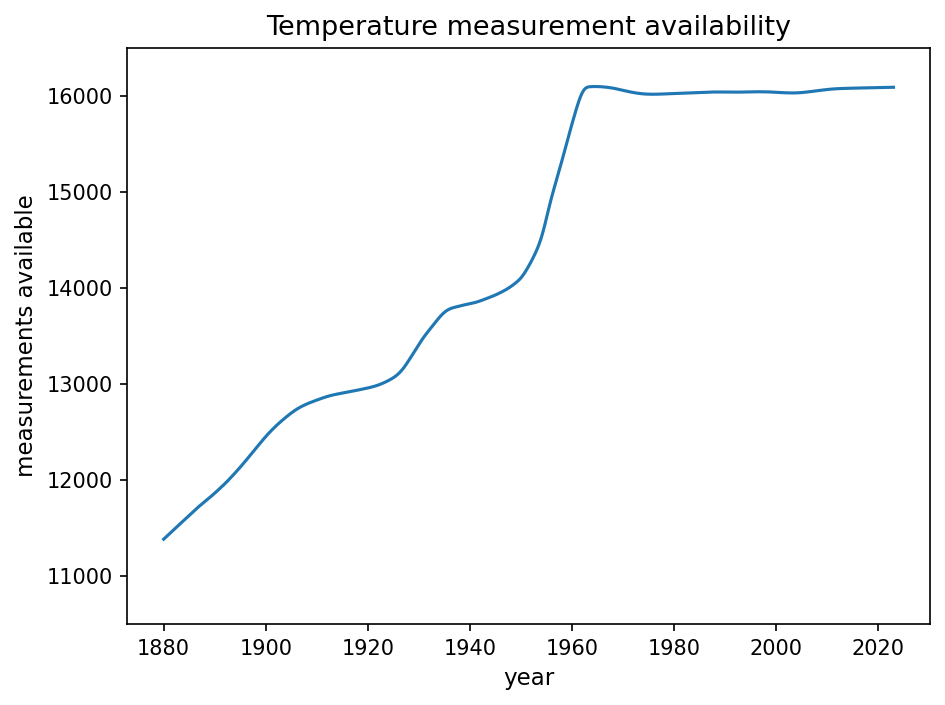

In [5]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

# perform LOWESS smoothing to remove seasonality
y_smooth = lowess(globalT.count(axis=0), np.linspace(1880, 2023,
                     len(globalT.count(axis=0))), frac=0.1)[:,1]

# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
"""
# measurements available vs. year
ax.plot(np.linspace(1880, 2023, len(globalT.count(axis=0))), 
        globalT.count(axis=0), color="tab:red")
"""
# measurements available vs. year (LOWESS smoothed)
ax.plot(np.linspace(1880, 2023, len(globalT.count(axis=0))), 
        y_smooth, color="tab:blue")
# titles
plt.title("Temperature measurement availability", fontsize=13)
plt.xlabel("year", fontsize=11)
plt.ylabel("measurements available",  fontsize=11)
plt.ylim(10500, 16500)
plt.tight_layout()
plt.show()

We can also view the distribution of the (up to) 16,200 temperature measurements available across the Earth's surface. As discussed, they are distributed evenly on a 2°x2° grid.

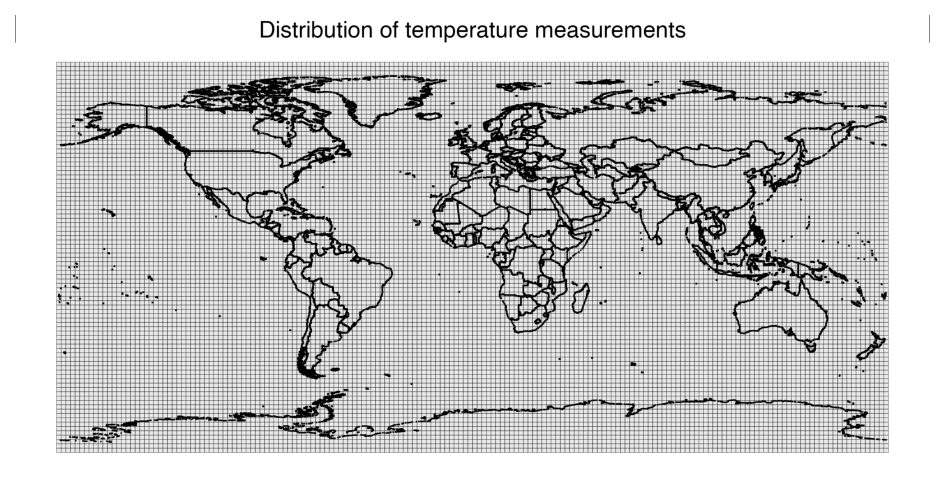

In [6]:
# load image
img = np.asarray(Image.open("../data/images/temp_grid.png"))
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot image
plt.imshow(img)
# remove axes
plt.axis('off')
plt.tight_layout()
plt.show()

We can now view and examine the mean global temperature drift relative to the 1951-1980 baseline. A 95% confidence interval is given as $t$ times the standard error of the yearly mean, where $t$ is the $t$-statistic. We use the $t$-statistic here rather than the usual $z$-statistic as the sample size is small ($n=12$ months per year) and so the central limit theorem does not apply.



In [7]:
from scipy import stats

# calculate t-statistic (95%, n=12 months)
t = stats.t.ppf(q=0.975, df=12-1)

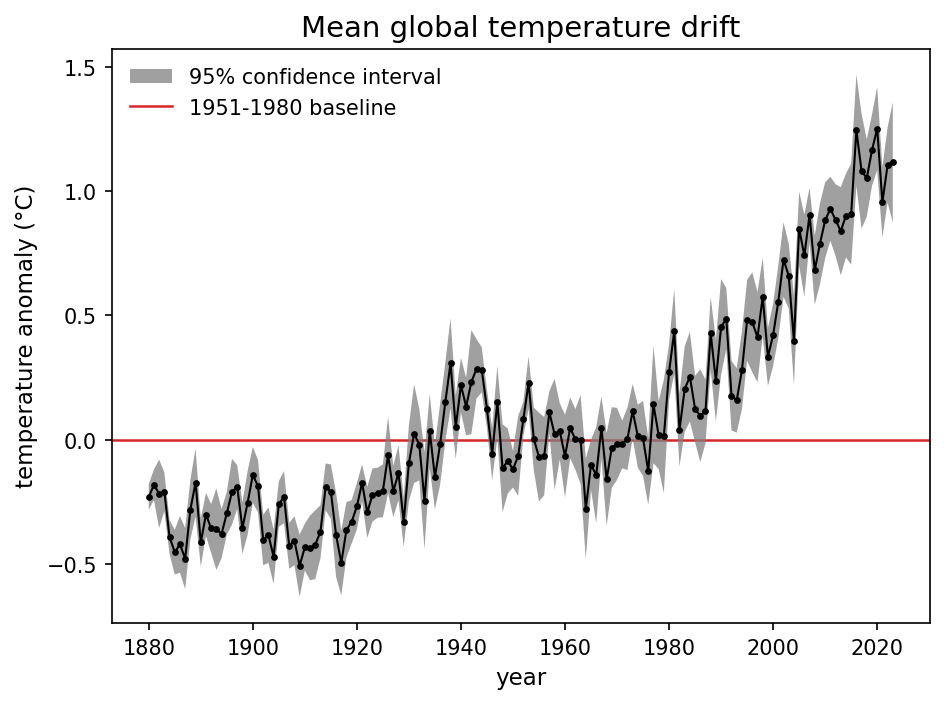

In [8]:
# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# data points
ax.plot(date, yearlyT, linewidth=1.0, color="black", zorder=2)
ax.scatter(date, yearlyT, color="black", s=5, marker="o", zorder=3)
# confidence interval (t*SE)
ax.fill_between(date, (yearlyT-t*yearlyT_SE), (yearlyT+t*yearlyT_SE),
                color='none', alpha=0.75, facecolor="grey", zorder=1, 
                label="95% confidence interval")
"""
# error bars (t*SE)
ax.errorbar(x=date, y=yearlyT, yerr=t*yearlyT_SE, ls="None", 
            color="black", capsize=2.5, elinewidth=1, markeredgewidth=0.75, zorder=3)
"""
# 1951-1980 baseline
plt.axhline(y=0, label="1951-1980 baseline", color="tab:red", linewidth=1.2,
            zorder=0)
# titles
plt.title("Mean global temperature drift", fontsize=14)
plt.xlabel("year", fontsize=11)
plt.ylabel("temperature anomaly (°C)", fontsize=11)
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.savefig("../data/images/temperature.png", dpi=300, facecolor="white")
plt.show()

We see that the global temperature anomaly has generally always increased, particularly in the last 60 years. This increase appears to be significant compared with the estimated uncertainty, suggesting that the mean global temperature is indeed increasing with respect to the baseline.

In [9]:
# show 2022 values
print(f"temperature anomaly: {yearlyT.loc[2022]:.2f}°C")
print(f"uncertainty (95%):   {t*yearlyT_SE.loc[2022]:.2f}°C")

temperature anomaly: 1.10°C
uncertainty (95%):   0.15°C


We estimate that the mean global temperature was 1.10±0.15°C above the 1951-1980 baseline in the last complete year (2022). This corresponds to an absolute mean global temperature of ~15.10°C in 2022.

## Establishing a relationship between the mean global temperature drift and the atmopsheric CO<sub>2</sub> level

There are two [CO<sub>2</sub> datasets](https://gml.noaa.gov/ccgg/trends/data.html) available from NOAA: global mothly averages dating back to 1979 and monthly measurements from Mauna Loa Observatory dating back to 1958. On average, the Mauna Loa measurements are only 0.24% greater than the global measurements during their common date range. Hence, we will use the Mauna Loa dataset as it provides an additional 21 years of measurements while still accurately representing the global CO<sub>2</sub> concentration.

In [10]:
# import co2 datasets
glo = pd.read_csv(dir + "processed/global_co2_PRO.csv")
mau = pd.read_csv(dir + "processed/mauna_co2_PRO.csv")

# match available months
mau = mau.loc[mau["year"] >= 1979]
mau = mau.iloc[:-2,].reset_index()

# mean difference
md = np.mean(mau['average']-glo['average'])/np.mean(glo['average'])*100
print(f"mean diff: {md:.2f}%")

mean diff: 0.24%


In [11]:
# import Mauna Loa co2 data
co2 = pd.read_csv(dir + "processed/mauna_co2_PRO.csv")

# match temperature data to available years
yearlyT_matched = yearlyT.loc[yearlyT.index.astype("int") >= min(co2["year"])]
yearlyT_SE_matched = yearlyT_SE.loc[yearlyT_SE.index.astype("int") >= min(co2["year"])]

# convert monthly co2 readings to yearly average
yearlyCO2 = co2.groupby(["year"])["average"].mean()
yearlyCO2_SE = co2.groupby(["year"])["average"].std() / \
                    np.sqrt(co2.groupby(["year"])["average"].count())

# available year range
years = yearlyCO2.index.values

We can then view the mean atmospheric CO<sub>2</sub> concentration as a function of time. Again, the uncertainty is given as $t$ times the standard error of the yearly mean due to the small sample size.

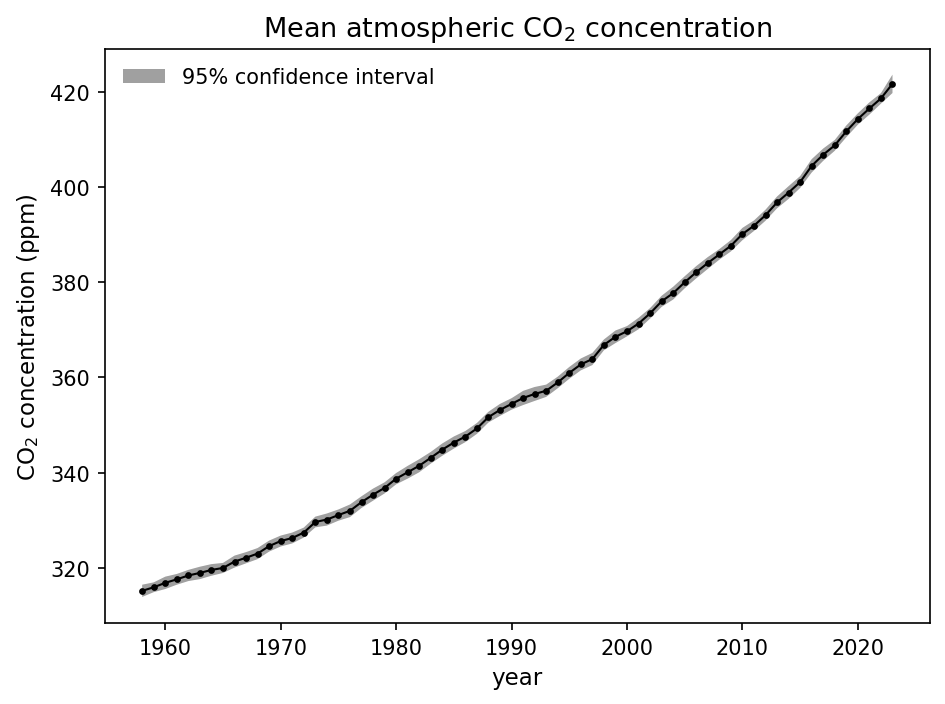

In [12]:
# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# data points
ax.plot(years, yearlyCO2, linewidth=1.0, color="black", zorder=2)
ax.scatter(years, yearlyCO2, color="black", s=5, marker="o", zorder=3)
# confidence interval (t*SE)
ax.fill_between(years, (yearlyCO2-t*yearlyCO2_SE), (yearlyCO2+t*yearlyCO2_SE),
                color='none', alpha=0.75, facecolor="grey", zorder=1, 
                label="95% confidence interval")
"""
# error bars (t*SE)
ax.errorbar(x=years, y=yearlyCO2, yerr=t*yearlyCO2_SE, ls="None", 
            color="black", capsize=2.5, elinewidth=1, markeredgewidth=0.75, zorder=3)
"""
# titles
plt.title("Mean atmospheric CO$_2$ concentration", fontsize=13)
plt.xlabel("year", fontsize=11)
plt.ylabel("CO$_2$ concentration (ppm)", fontsize=11)
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()

We can compare the atmospheric CO<sub>2</sub> concentration with the temperature anomaly by standardising both variables and plotting them. The errorbars show estimated 95% confidence intervals.

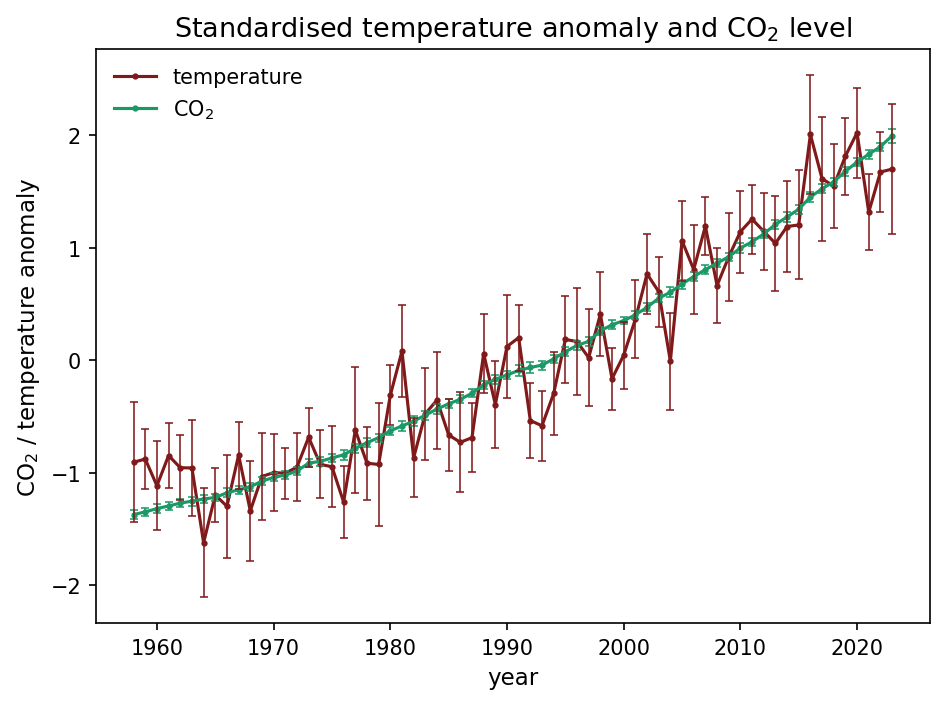

In [13]:
# dataframe containing temperature and co2
co2_temp_dict = {"temp":np.array(yearlyT_matched), "co2":np.array(yearlyCO2)}
co2_temp = pd.DataFrame(co2_temp_dict, index=years)
# standardize the temperature anomaly and co2 levels
normal_co2_temp = (co2_temp - co2_temp.mean())/co2_temp.std()

# dataframe containing SEs
co2_temp_SE_dict = {"temp":np.array(yearlyT_SE_matched), "co2":np.array(yearlyCO2_SE)}
co2_temp_SE = pd.DataFrame(co2_temp_SE_dict, index=years)
# standardize the SEs
normal_co2_temp_SE = (co2_temp_SE)/co2_temp.std()

# save
co2_temp.to_csv("../data/processed/data_matched.csv", index=True)

# visualise standardised co2 and temp vs. year
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot data points
ax.plot(years, normal_co2_temp["temp"], "o-", color=(0.5, 0.1, 0.1), 
        label="temperature", markersize=2)
ax.plot(years, normal_co2_temp["co2"], "o-", color=(0.1, 0.6, 0.4), 
        label="CO$_2$", markersize=2)
# add error bars (t*SE)
ax.errorbar(x=years, y=normal_co2_temp["co2"], yerr=t*normal_co2_temp_SE['co2'], 
            ls = "None", color=(0.1, 0.6, 0.4), capsize=2, elinewidth=0.75, 
            markeredgewidth=0.75, zorder=3)
ax.errorbar(x=years, y=normal_co2_temp["temp"], yerr=t*normal_co2_temp_SE['temp'], 
            ls = "None", color=(0.5, 0.1, 0.1), capsize=2, elinewidth=0.75, 
            markeredgewidth=0.75, zorder=3)
# titles
plt.title("Standardised temperature anomaly and CO$_2$ level", fontsize=13)
plt.ylabel("CO$_2$ / temperature anomaly ", fontsize=11)
plt.xlabel("year", fontsize=11)
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

We can also compare by plotting the temperature anomaly against the CO<sub>2</sub> concentration and colouring the points by year. Again, the errorbars show estimated 95% confidence intervals.

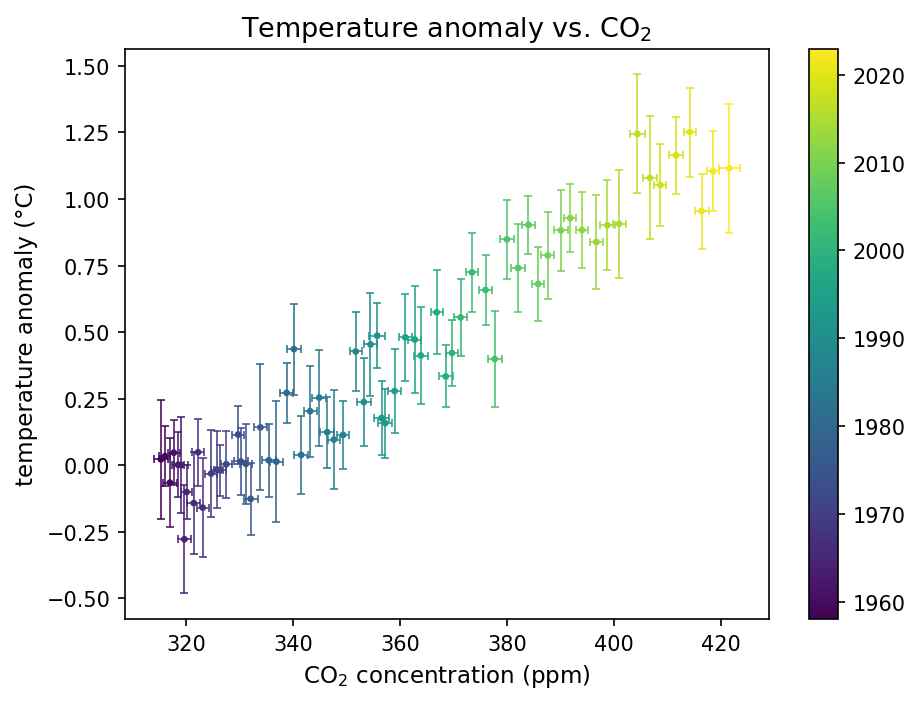

In [14]:
# convert from pandas to numpy array
arr_temp = np.array(yearlyT_matched)
arr_co2 = np.array(yearlyCO2)

# plot temperature vs. co2
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
sc = ax.scatter(arr_co2, arr_temp, c = years, s = 5)
cols = sc.to_rgba(years)
# plot points with errorbars
for x, y, xerr, yerr, color in zip(arr_co2, arr_temp, yearlyCO2_SE, yearlyT_SE_matched, cols):
    ax.errorbar(x=x, y=y, xerr=t*xerr, yerr=t*yerr, ls="None", capsize=2, 
                elinewidth=0.75, color=color, markeredgewidth=0.75)
# titles
plt.title("Temperature anomaly vs. CO$_2$", fontsize=13)
plt.xlabel("CO$_2$ concentration (ppm)", fontsize=11)
plt.ylabel("temperature anomaly (°C)", fontsize=11)
fig.colorbar(sc)
plt.tight_layout()
plt.show()

Both plots above show a positive relationship between temperature anomaly and CO<sub>2</sub> concentration, with earlier years having lower CO<sub>2</sub> concentrations and lower temperature anomalies and later years having higher CO<sub>2</sub> concentrations and higher temperature anomalies.    

### Pearson correlation

It is tempting to now calculate the Pearson correlation coefficient between these variables in order to further quantify this apparently linear relationship.

In [15]:
from scipy.stats import pearsonr

# calculate correlation between temperature and co2
cor = pearsonr(yearlyT_matched, yearlyCO2)[0]
print(f"correlation coef.: {cor:.3f}")

correlation coef.: 0.957


Indeed, we find a very high correlation coefficient of 0.957. However, when dealing with time series data, the standard Pearson correlation coefficient does not always have a useful interpretation. To see why this is the case, consider two arrays of 100 random numbers which are distributed as $\mathcal{N}(0,25)$.

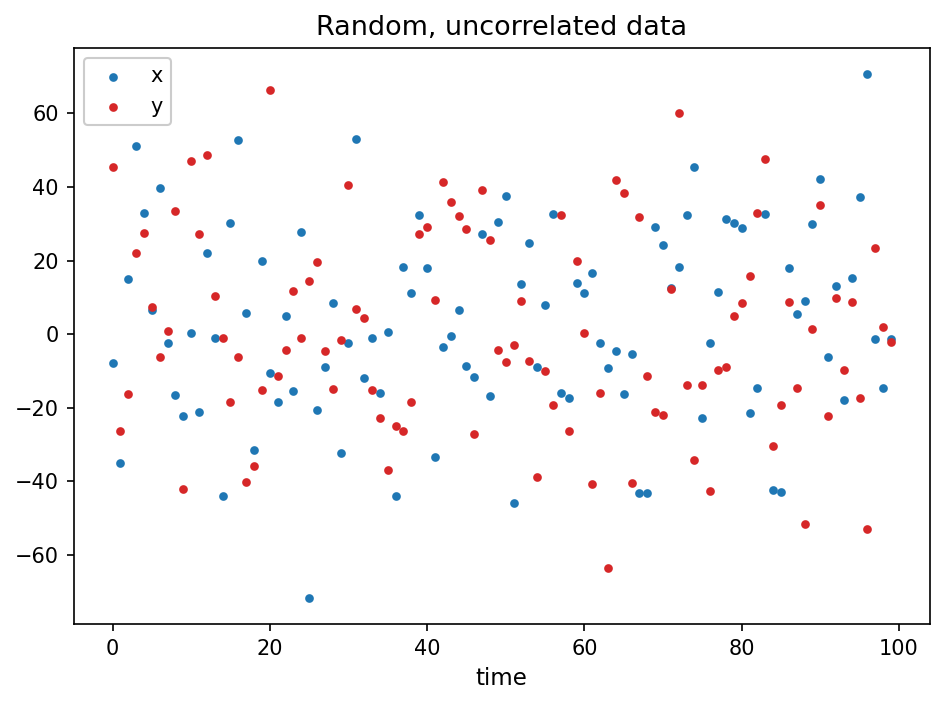

Pearson correlation coef.: -0.002


In [16]:
# fictitious time series
time = np.arange(0,100)

# random normal data
x = np.random.normal(0, 25, 100)
y = np.random.normal(0, 25, 100)

# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot points
ax.scatter(time, x, label="x", s=10, color="tab:blue")
ax.scatter(time, y, label="y", s=10, color="tab:red")
# titles
plt.title("Random, uncorrelated data", fontsize=13)
plt.xlabel("time", fontsize=11)
plt.legend(loc="upper left", framealpha=1)
plt.tight_layout()
plt.show()

# calculate Pearson correlation
print(f"Pearson correlation coef.: {pearsonr(x, y)[0]:.3f}")

Now, add a linear trend to the data. The y-axis separation is irrelevant for our purposes but helps with visualisation.

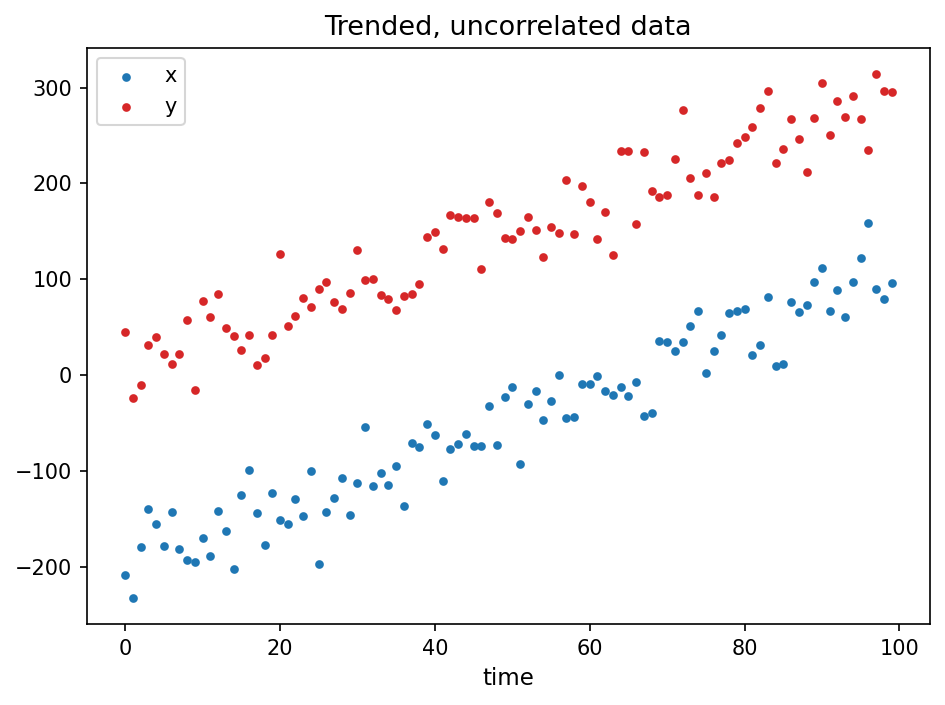

Pearson correlation coef.: 0.914


In [17]:
# create a linear time trend
time_trend = 3 * time

# add on the same random numbers to this time trend
new_x = time_trend + x - 200
new_y = time_trend + y

# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot points
ax.scatter(time, new_x, label="x", s=10, color="tab:blue")
ax.scatter(time, new_y, label="y", s=10, color="tab:red")
plt.title("Trended, uncorrelated data", fontsize=13)
plt.xlabel("time", fontsize=11)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# calculate Pearson correlation
print(f"Pearson correlation coef.: {pearsonr(new_x, new_y)[0]:.3f}")

As can be seen, the random data has a correlation coefficient close to zero, but once the same trend is introduced to both data sets, the correlation coefficient becomes close to the maximum of 1. This demonstrates that the Pearson correlation coefficient can show spurious correlations when two datasets change in the same way with time, making it hard to distinguish between related variables having high correlations and spurious correlations of two unrelated time series. Hence, it is not appropriate to use the Pearson correlation coefficient with trended (non-stationary) time series data.

### Other correlation measures

Having shown that the standard Pearson correlation coefficient is inappropriate to use with trended time series data, we will now consider a correlation method that is appropriate:

- the cross-correlation function.

However, we must first consider the issue of stationarity.

### Stationarity

In order to use the above methods, we must satisfy the condition of weak stationarity. A time series is said to be weakly stationary if its mean and (auto-)covariance do not vary with respect to time ([Shumway and Stoffer, 2017](https://doi.org/10.1007/978-3-319-52452-8)).

There are two main methods that can be used to construct a stationary time series:

- de-trending: fit a model which captures the trend of the series and subtract.

- differencing: calculate the difference between adjacent entries of the series.

The main benefit of de-trending is that it gives a functional estimate of the stationary generating process, while the main advantage of differencing is that it requires no model selection or parameter estimation. As we are mainly interested in just obtaining a stationary time series, we opt to use the differencing method.

The first difference of a time series $x_t$ is given by
$$
\nabla x_t = x_t - x_{t-1}
$$
and the second difference is given by
$$
\nabla ^2 x_t = \nabla x_t - \nabla x_{t-1} = x_t -2x_{t-1} -x_{t-2}.
$$

A time series can be checked for stationarity using either statistical tests or visual methods. Two common [statistical tests](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) are:

- the ADF test: H<sub>0</sub> unit root, H<sub>A</sub> no unit root.

- the KPSS test: H<sub>0</sub> trend stationary, H<sub>A</sub> unit root.

Hence, a stationary time series can be indicated by a significant ADF test and a non-significant KPSS test. If a time series is found to be non-stationary, then differencing can be applied to achieve stationarity.

In [18]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
from statsmodels.tsa.stattools import adfuller, kpss

def stationary_test(ts, n):
    """
    Check a time series for stationarity.

    Parameters
    ----------
    ts : timeseries
    n : maximum number of lags

    Returns
    -------
    None

    """
    # perform tests
    adf = adfuller(x=ts, maxlag=n)
    kps = kpss(x=ts, nlags=n)

    # print results
    print(f"ADF: p={adf[1]:.2f} at {adf[2]} lags")
    print(f"KPSS: p={kps[1]:.2f} at {kps[2]} lags")

    if(adf[1]<0.05 and kps[1]>0.05):
        print("=> series is stationary")
    else:
        print("=> series is not stationary")
        

In [19]:
%%capture --no-stdout
# (suppressing warnings)

stationary_test(co2_temp["temp"], 5)
print("")
stationary_test(co2_temp["co2"], 5)

ADF: p=0.98 at 3 lags
KPSS: p=0.01 at 5 lags
=> series is not stationary

ADF: p=1.00 at 2 lags
KPSS: p=0.01 at 5 lags
=> series is not stationary


Neither time series is stationary, so apply first differencing to the data.

In [20]:
# apply first differencing
diff1 = co2_temp.copy().diff().dropna()

In [21]:
%%capture --no-stdout
# (suppressing warnings)

stationary_test(diff1["temp"], 5)
print("")
stationary_test(diff1["co2"], 5)

ADF: p=0.00 at 5 lags
KPSS: p=0.10 at 5 lags
=> series is stationary

ADF: p=0.72 at 3 lags
KPSS: p=0.01 at 5 lags
=> series is not stationary


Apply second differencing to the CO<sub>2</sub> data.

In [22]:
# apply second differencing to co2 only
diff2 = diff1.copy()
diff2["co2"] = diff2["co2"].diff().dropna()
diff2 = diff2.iloc[1:,:]

In [23]:
%%capture --no-stdout
# (suppressing warnings)

stationary_test(diff2["temp"], 5)
print("")
stationary_test(diff2["co2"], 5)

ADF: p=0.00 at 5 lags
KPSS: p=0.10 at 5 lags
=> series is stationary

ADF: p=0.00 at 5 lags
KPSS: p=0.10 at 5 lags
=> series is stationary


The ADF and KPSS tests now indicate that both the temperature and CO<sub>2</sub> time series are stationary. Indeed, we can see below that the differenced time series now appear to have constant means and variances, as required.

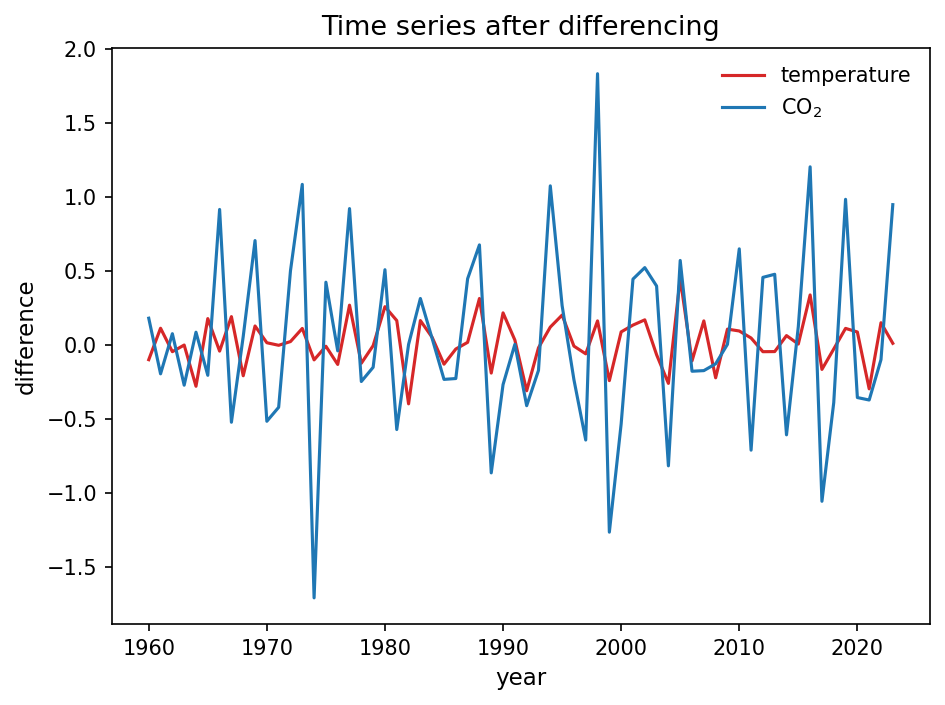

In [24]:
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot differenced series
ax.plot(diff2.index.values, diff2["temp"], color="tab:red", label="temperature")
ax.plot(diff2.index.values, diff2["co2"], color="tab:blue", label="CO$_2$")
# titles
plt.title("Time series after differencing", fontsize=13)
plt.xlabel("year", fontsize=11)
plt.ylabel("difference", fontsize=11)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### Cross-correlation

For jointly stationary time series $x_t$ and $y_t$, the cross-correlation function at lag $h$ is given by
$$
\rho_{xy}(h)=\frac{\gamma_{xy}(h)}{\sqrt{\gamma_x(0)\gamma_y(0)}}
$$
where $\gamma_{x/y}(0)$ is the autocovariance and $\gamma_{xy}(h)$ is the cross-covariance function ([Shumway and Stoffer, 2017](https://doi.org/10.1007/978-3-319-52452-8)). This quantity is bounded by $-1\leq\rho_{xy}(h)\leq1$, allowing us to quantify the relationship between $x_t$ and $y_t$ at various lags $h$. The interpretation is similar to the standard correlation coefficient.

We will perform the cross-correlation calculations in __R__ using the [testcorr](https://cran.r-project.org/web/packages/testcorr/index.html) package. This package also performs tests to determine the significance of any observed non-zero cross-correlations. The usual confidence band for zero cross-correlation is given by $\pm z_{\alpha/2}/\sqrt{n}$, however it is known that this band may not be appropriate for time series which are dependent or heteroskedastic ([Dalla, Giraitis and Phillips, 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3564701)). Hence, this package also implements robust confidence bands developed by the same authors which allow for non-i.i.d. time series.

We can now view the cross-correlation of temperature anomaly with CO<sub>2</sub> concentration as a function of the number of lags, as calculated in __R__.

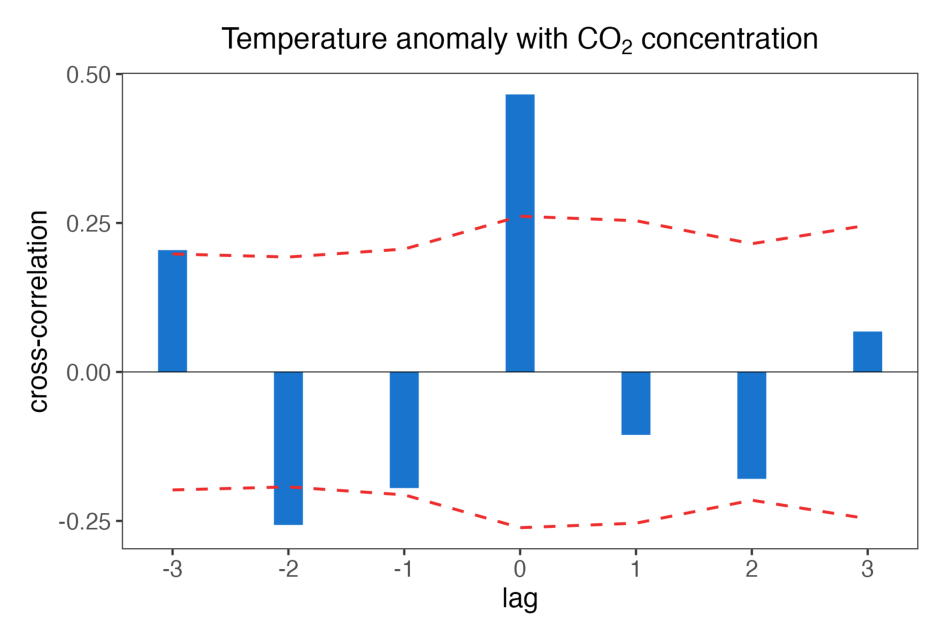

In [25]:
# load image
img = np.asarray(Image.open("../data/images/corr_plot_1.png"))
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot image
plt.imshow(img)
# remove axes
plt.axis('off')
plt.tight_layout()
plt.show()

We see that the main peak is at lag 0 with a cross-correlation value of 0.466. This indicates that there is moderate positive correlation between temperature anomaly and CO<sub>2</sub> concentration, i.e. an increase in CO<sub>2</sub> concentration is associated with an increase in temperature anomaly. 

This cross-correlation peak is significantly different from zero at the 95% level. The robust test statistic was $\tilde{t}$ = 3.49 with a $p$-value of 0.00048. Hence, we reject the null hypothesis that $\rho_{xy}(0)=0$ and conclude that there is a non-zero cross-correlation of 0.466 between the temperature anomaly and CO<sub>2</sub> concentration at lag 0.

## Correlations with other variables

We will now examine if the rising temperatures and CO<sub>2</sub> concentrations can be explained by natural causes. We will consider the following:

- Is the rising global temperature caused by a similar increase in solar irradiance?

- Are the rising CO<sub>2</sub> concentrations caused by a similar increase in volcanic activity?

If neither of these are the case, then we would conclude that the rising temperatures and CO<sub>2</sub> levels are unlikely to be of natural origin, i.e. they are induced by human activities.

In [26]:
# volcano data
volcano = pd.read_csv(dir+"processed/volcano_PRO.csv", delimiter=',', index_col=0)
volcano = volcano.loc[volcano.index.astype("int") >= min(co2["year"])]
volcano = volcano.loc[volcano.index.astype("int") <= 2022]

# irradiance data
irradiance = pd.read_csv(dir+"processed/irradiance_PRO.csv", delimiter=',', usecols=[0,1,2], index_col=0)
irradiance = irradiance.loc[irradiance.index.astype("int") >= min(co2["year"])]

# dataframe containing volcano and irradiance
other_dict = {"volcano":np.array(volcano).reshape(len(np.array(volcano))), 
              "irradiance":np.array(irradiance["TSI"]).reshape(len(np.array(irradiance["TSI"])))}
other = pd.DataFrame(other_dict, index=years[:-1])

# save
other.to_csv("../data/processed/other_data_matched.csv", index=True)

We can plot and examine the volcanic activity and the solar irradiance data. The 95% confidence interval on the total solar irradiance is given as 1.96 times the reported $1\sigma$ estimates.

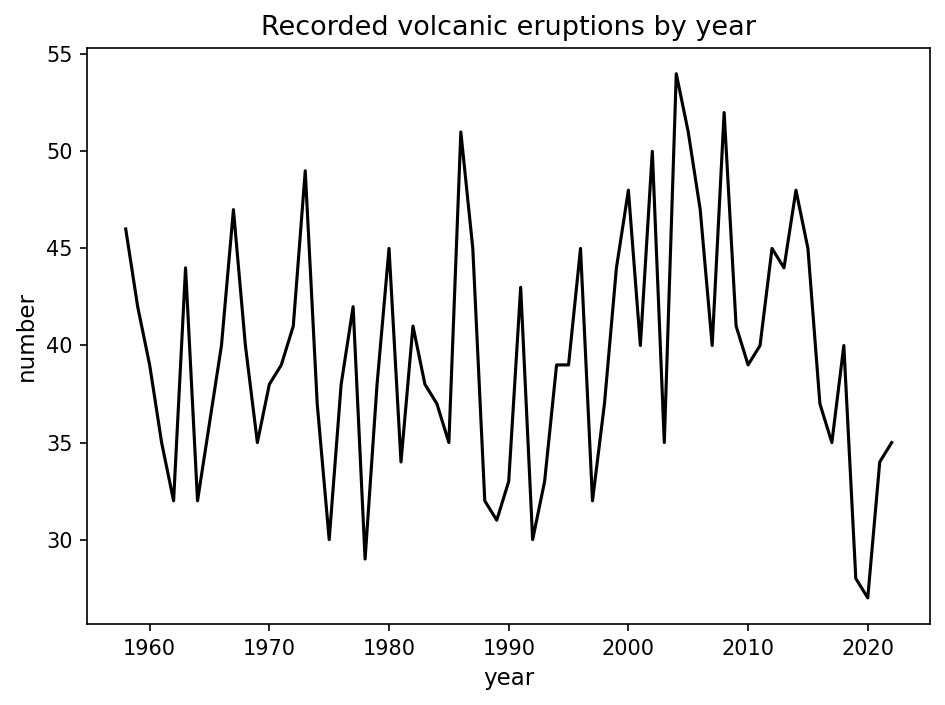

In [27]:
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot volcano data (counts - no uncertainty)
ax.plot(volcano.index.values, volcano["count"], color="black")
# titles
plt.title("Recorded volcanic eruptions by year", fontsize=13)
plt.xlabel("year", fontsize=11)
plt.ylabel("number", fontsize=11)
plt.tight_layout()
plt.savefig("../data/images/volcano.png", dpi=300, facecolor="white")
plt.show()

The volcanic activity data is stationary.

In [28]:
%%capture --no-stdout
# (suppressing warnings)

stationary_test(volcano, 3)

ADF: p=0.00 at 0 lags
KPSS: p=0.10 at 3 lags
=> series is stationary


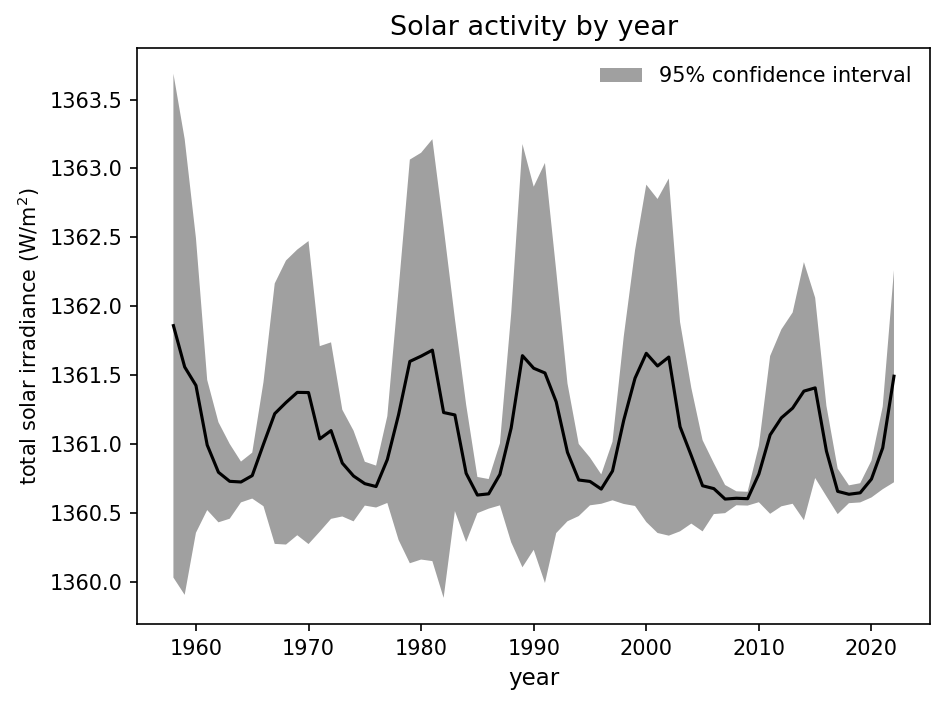

In [29]:
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot volcano data
ax.plot(irradiance.index.values, irradiance["TSI"], color="black")
# confidence interval (1.96 * 1sigma estimate)
ax.fill_between(irradiance.index.values, (irradiance["TSI"]-1.96*irradiance["TSI_UNC"]), 
                (irradiance["TSI"]+1.96*irradiance["TSI_UNC"]), color='none', alpha=0.75, 
                facecolor="grey", zorder=1, label="95% confidence interval")
"""
# error bars (1.96 * 1sigma estimate)
ax.errorbar(x=irradiance.index.values, y=irradiance["TSI"], yerr=1.96*irradiance["TSI_UNC"], 
            ls="None", color="black", capsize=2.5, elinewidth=1, markeredgewidth=0.75, zorder=3)
"""
# titles
plt.title("Solar activity by year", fontsize=13)
plt.xlabel("year", fontsize=11)
plt.ylabel("total solar irradiance ($\mathrm{W/m^2}$)")
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.savefig("../data/images/solar.png", dpi=300, facecolor="white")
plt.show()

Clearly, the solar irradiance data has seasonality which will have to be removed to ensure stationarity. There is no obvious trend present. This seasonality is caused by the [solar cycle](https://en.wikipedia.org/wiki/Solar_cycle), which typically lasts 11 years.

We can remove the seasonality by differencing at an 11 year interval.

In [30]:
# apply first differencing to irradiance data (11 year interval)
irradiance_diff1 = irradiance.diff(11)[11:]["TSI"]

We can now check if the solar irradiance series is stationary.

In [31]:
%%capture --no-stdout
# (suppressing warnings)

stationary_test(irradiance_diff1, 3)

ADF: p=0.00 at 2 lags
KPSS: p=0.10 at 3 lags
=> series is stationary


Both series are now stationary, so we can now examine the cross-correlations from __R__. The cross-correlations are shown for ±3 lags for clarity, but were tested to ±10 lags with the same results.

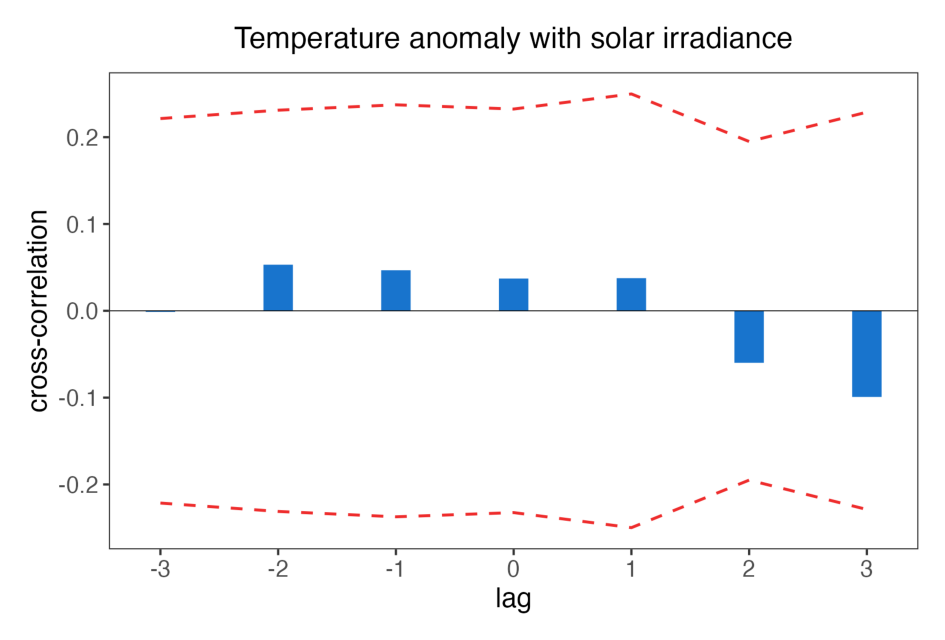

In [32]:
# load image
img = np.asarray(Image.open("../data/images/corr_plot_2.png"))
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot image
plt.imshow(img)
# remove axes
plt.axis('off')
plt.tight_layout()
plt.show()

Clearly, there is no correlation between the temperature anomaly and the solar irradiance. The cross-correlation function never has a magnitude greater than ~0.1 and none of the observed peaks are significantly different from zero at a 95% level. 

The peaks all have $p$-values $\gg$ 0.05. Hence, we fail to reject the null hypothesis that $\rho_{xy}(h)=0$ for any $h$ and cannot conclude that there is a non-zero cross-correlation between the temperature anomaly and the solar irradiance.

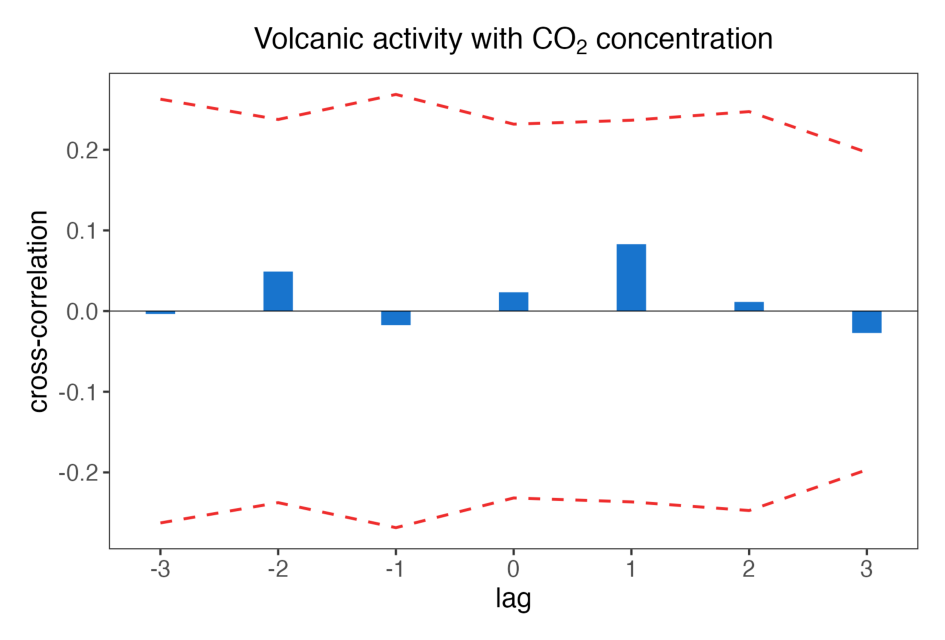

In [33]:
# load image
img = np.asarray(Image.open("../data/images/corr_plot_3.png"))
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot image
plt.imshow(img)
# remove axes
plt.axis('off')
plt.tight_layout()
plt.show()

Clearly, there is no correlation between the volcanic activity and the CO<sub>2</sub> concentration. The cross-correlation function never has a magnitude greater than ~0.1 and none of the observed peaks are significantly different from zero at a 95% level.

The peaks all have $p$-values $\gg$ 0.05. Hence, we fail to reject the null hypothesis that $\rho_{xy}(h)=0$ for any $h$ and cannot conclude that there is a non-zero cross-correlation between the CO<sub>2</sub> concentration and volcanic activity.

As there appears to be no correlation between the global temperature anomaly and total solar irradiance, and the CO<sub>2</sub> concentration and volcanic activity, we conclude that the rising temperatures and CO<sub>2</sub> levels are unlikely to be of natural origin, i.e. they are induced by human activities. 

## Modelling the mean global temperature drift

A very simple way of estimating the global temperature drift in the future would be to run a simple linear regression on the temperature anomaly data.

In [34]:
from scipy.stats import linregress as lm

In [35]:
# times into future
t = np.arange(1958, 2101)

#run linear regression
linmod = lm(x = years, y = arr_temp)

#print the slope and intercept
print(f"intercept: {linmod.intercept:.3f}\nslope: {linmod.slope:.3f}")

intercept: -40.303
slope: 0.020


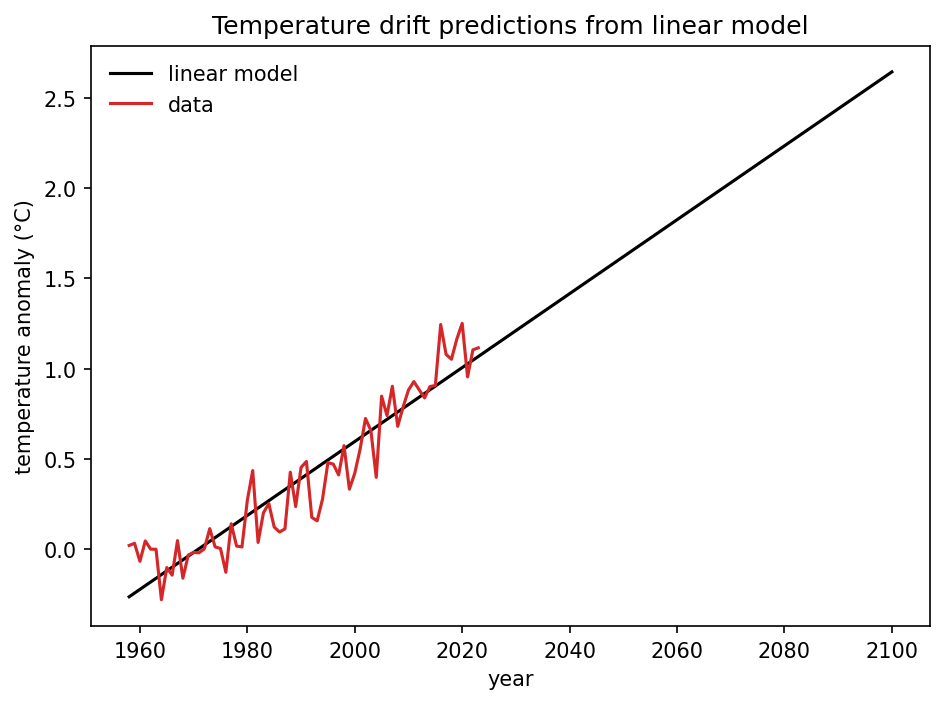

In [36]:
#predictions
preds = linmod.intercept + linmod.slope * t

# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, preds, label = "linear model", color = "black")
ax.plot(years, arr_temp, label = "data", color = "tab:red")

plt.title("Temperature drift predictions from linear model")
plt.xlabel("year")
plt.ylabel("temperature anomaly (°C)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

As can be seen, this simple fit indicates that we would expect to see a temperature anomaly of 2.64 °C by 2100.

## Developing a simple model of CO<sub>2</sub> and temperature drift.

A simple model of temperature and CO<sub>2</sub> could be described by the differential equations
$$\dfrac{dT}{dt} = \alpha \dfrac{dC}{dt} + \beta C$$
$$\dfrac{dC}{dt} = \gamma$$
where $T$ represents temperature anomaly and $C$ represents CO<sub>2</sub> level which is increasing linearly with rate $\gamma$. This differential equation gives that the rate of change of the temperature anomaly is proportional to the rate of change of the CO<sub>2</sub> level and the CO<sub>2</sub> level itself. The parameters $\alpha, \ \beta$ and $\gamma$ can be determined by fitting the solution of the ODE to the temperature and CO<sub>2</sub> data using a least squares optimization algorithm.

In [37]:
# required packages for solving odes and least square optimization problems
from scipy.integrate import odeint as ode
from scipy.optimize import least_squares as ls

# define the function that describes the above ODEs
def fun(y, t, alpha, beta, gamma):
    T, C = y # current temp and CO2 
    dCdt = gamma # derivative of CO2
    dydt = [alpha * dCdt + beta * C, dCdt] 
    return dydt

In [38]:
# define a function that calculates the difference between
# ODE solution and the data at each time point
def residuals(x):
    y0 = [arr_temp[0], arr_co2[0]]
    sol = ode(fun, y0, years, args = (x[0], x[1], x[2]))
    temp_res = arr_temp - sol[:, 0] 
    co2_res = arr_co2 - sol[:, 1]
    tot_res = np.append(temp_res, co2_res)
    return tot_res

In [39]:
# initial guess for parameters
x0 = np.array([1,1,1,1])

# apply least squares optimization
lsfit = ls(residuals, x0)

# store optimal parameters in opt
opt = lsfit.x

In [40]:
# get the fitted values
print(f"alpha: {opt[0]:.3f} \nbeta:   {opt[1]:.3f} \ngamma:  {opt[2]:.3f} ")

alpha: -0.111 
beta:   0.000 
gamma:  1.410 


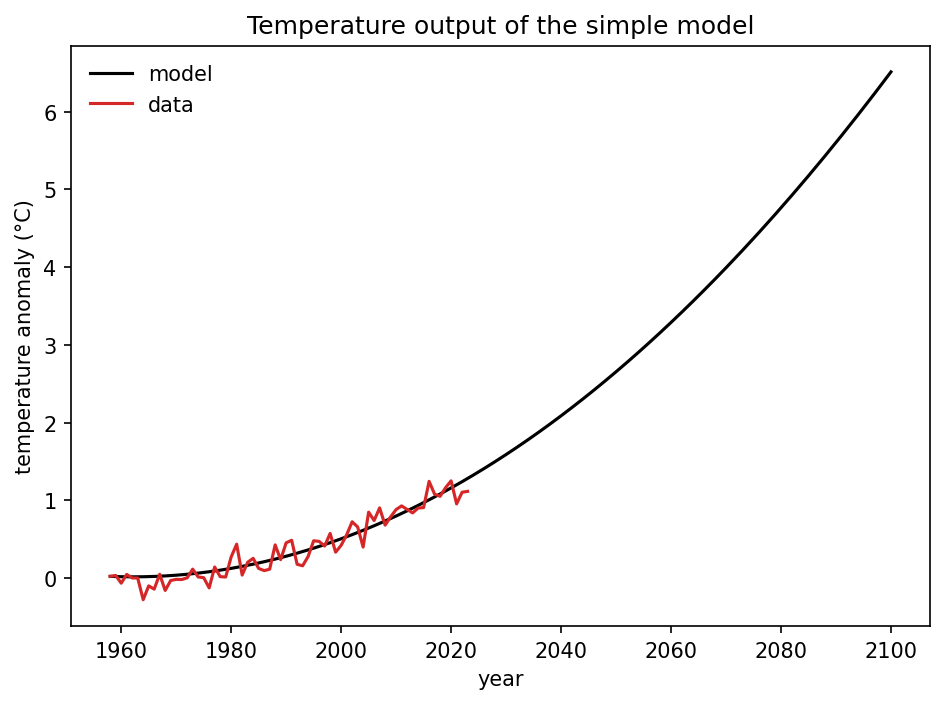

In [41]:
# solve
sol = ode(fun, [arr_temp[0], arr_co2[0]], t, args = (opt[0], opt[1], opt[2]))


# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, sol[:,0], label = "model", color = "black")
ax.plot(years, arr_temp, label = "data", color = "tab:red")

plt.title("Temperature output of the simple model")
plt.xlabel("year")
plt.ylabel("temperature anomaly (°C)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

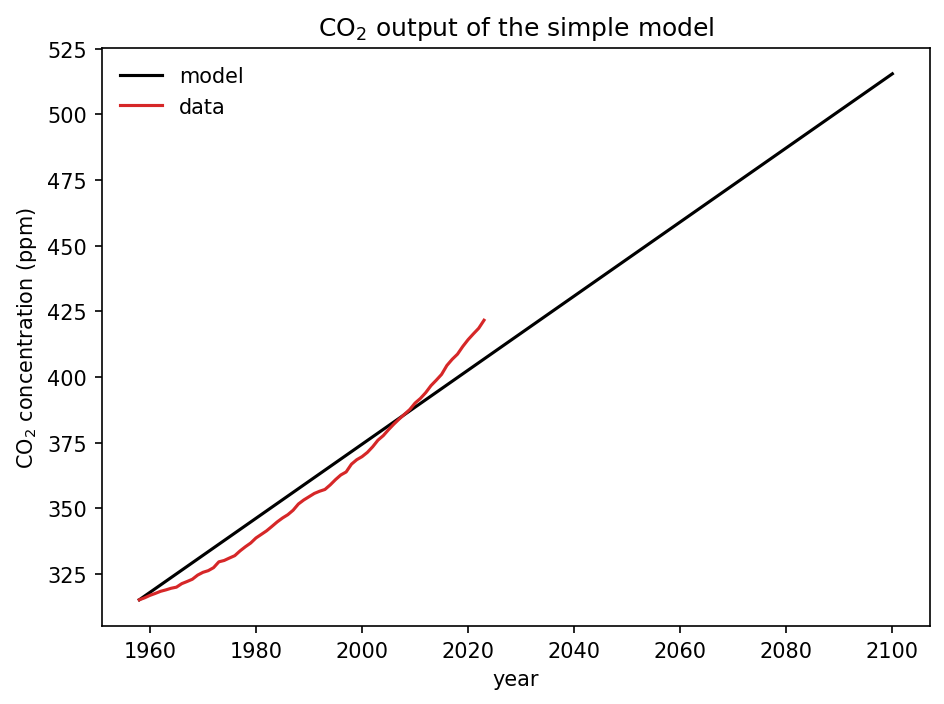

In [42]:
# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, sol[:,1], label = "model", color = "black")
ax.plot(years, arr_co2, label = "data", color = "tab:red")

plt.title("CO$_2$ output of the simple model")
plt.xlabel("year")
plt.ylabel("CO$_2$ concentration (ppm)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

As can be seen from the above plot, the CO<sub>2</sub> data is not captured particularly well by this model, which means that the temperature anomaly will not be well represented under the model. This is because the model is a coupled set of differential equations, so the temperature anomaly relies on the CO<sub>2</sub> level in the model. The above simple model is changed to reflect the non-linearity of the CO<sub>2</sub> data. Under this model, it is assumed that the rate of change of the CO<sub>2</sub> level is increasing exponentially with time since the time at first measurement $t_0$.  

$$\dfrac{dT}{dt} = \alpha \dfrac{dC}{dt} + \beta C$$
$$\dfrac{dC}{dt} = \gamma \exp(\phi\cdot [t-t_0])$$

In [43]:
# second attempt at a simple model of temperature based on CO2
def fun1(y, t, alpha, beta, gamma, phi):
    T, C = y
    dCdt = gamma * np.exp(phi * (t-1958))
    dydt = [alpha * dCdt + beta * C, dCdt]
    return dydt

In [44]:
# define a function that calculates the difference between 
# ODE solution and the data at each time point
def residuals1(x):
    y0 = [arr_temp[0], arr_co2[0]]
    sol = ode(fun1, y0, years, args = (x[0], x[1], x[2], x[3]))
    temp_res = arr_temp - sol[:, 0] 
    co2_res = arr_co2 - sol[:, 1]
    tot_res = np.append(temp_res, co2_res)
    return tot_res

In [45]:
# initial guess for parameters
x0 = np.array([1,1,1,0.01])

# apply least squares optimization
lsfit1 = ls(residuals1, x0)

# store optimal parameters in opt1
opt1 = lsfit1.x

In [46]:
#get the fitted values
print(f"alpha: {opt1[0]:.3f} \nbeta: {opt1[1]:.3f} \ngamma: {opt1[2]:.3f} \nphi:   {opt1[3]:.3f}")

alpha: 0.029 
beta: -0.000 
gamma: 0.875 
phi:   0.018


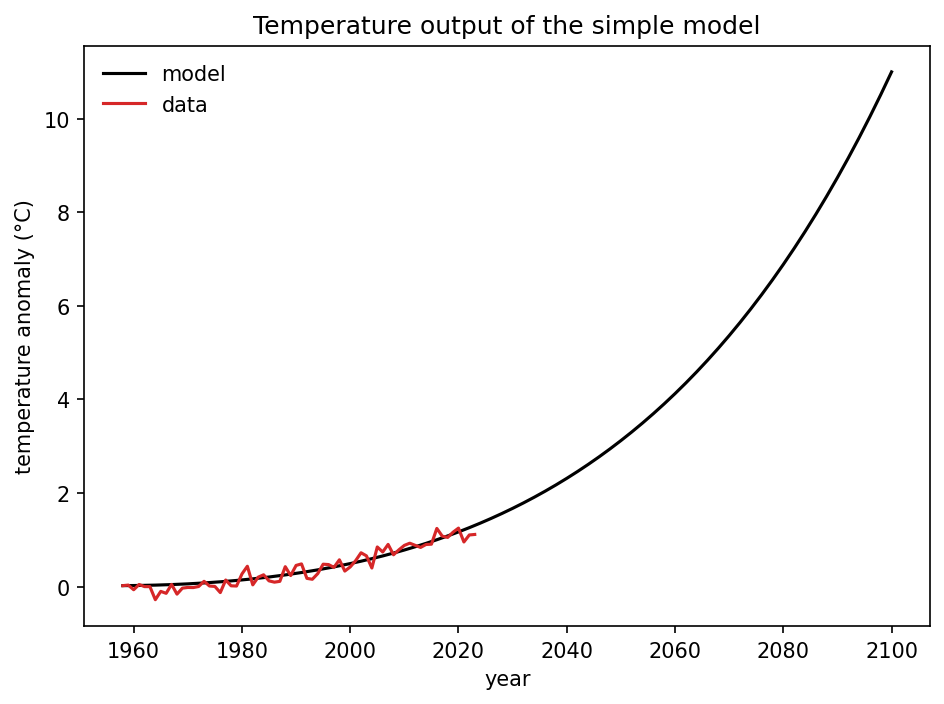

In [47]:
# solve
sol1 = ode(fun1, [arr_temp[0], arr_co2[0]], t, args = (opt1[0], opt1[1], opt1[2], opt1[3]))

# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, sol1[:,0], label = "model", color = "black")
ax.plot(years, arr_temp, label = "data", color = "tab:red")

plt.title("Temperature output of the simple model")
plt.xlabel("year")
plt.ylabel("temperature anomaly (°C)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

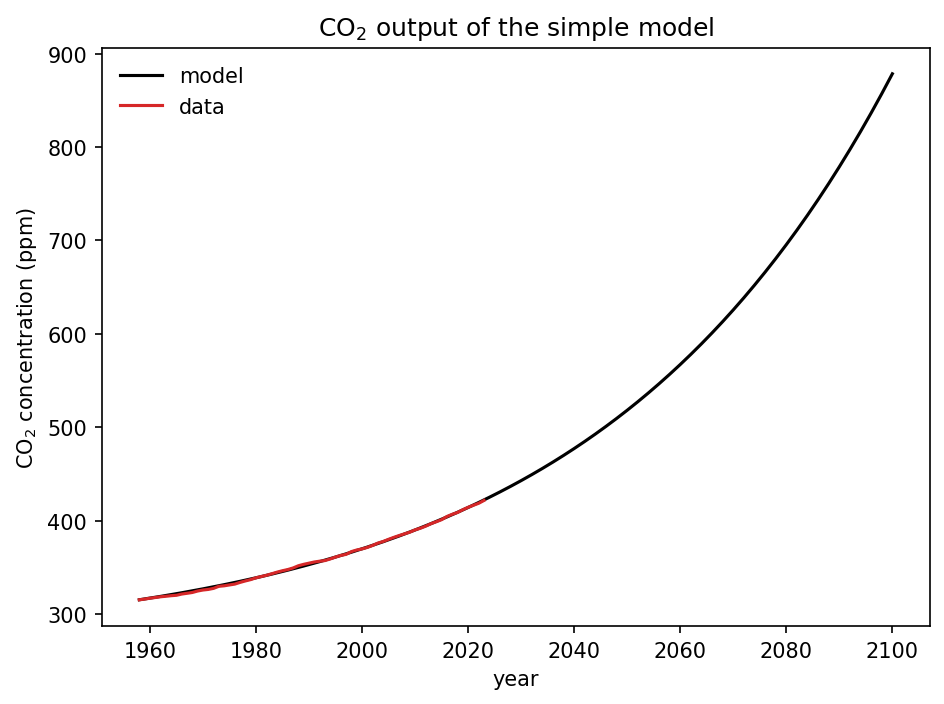

In [48]:
# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, sol1[:,1], label = "model", color = "black")
ax.plot(years, arr_co2, label = "data", color = "tab:red")

plt.title("CO$_2$ output of the simple model")
plt.xlabel("year")
plt.ylabel("CO$_2$ concentration (ppm)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

This model fits both the CO<sub>2</sub> and temperature anomaly data quite well. The predictions for later years seem unrealistic though, with the CO<sub>2</sub> increasing by 400 ppm to over 800 ppm and the temperature anomaly reaching over 10 °C by 2100. The model is therefore adjusted so that the exponential term for the rate of change of CO<sub>2</sub> has an extra term which decreases the rate of change from the year 2024. This will stop the model from blowing off to unrealistic values of the CO<sub>2</sub> and also account for possible reductions in the rate at which CO<sub>2</sub> levels are increasing due to the reduction of use of fossil fuels etc. The model is now 
$$
\begin{align*}
\dfrac{dT}{dt} &= \alpha \dfrac{dC}{dt} + \beta C \\
\dfrac{dC}{dt} &= \begin{cases}
\gamma \exp(\phi\cdot [t - t_0]), & t < 2024 \\
\gamma \exp(\phi\cdot [2024 - t_0]- \lambda \cdot [t-2024]), & t \geq 2024
\end{cases}
\end{align*}
$$
In the below code $\lambda$ is set to 0.005 as this value leads to reasonable predictions for the model, however there is no way of finding which $\lambda$ is best here since there is no available data to fit to after 2023. 

In [49]:
# third attempt at a simple model of temperature based on CO2
def fun2(y, t, alpha, beta, gamma, phi):
    T, C = y
    if t < 2024:
        dCdt = gamma * np.exp(phi * (t-1958))
    elif t >= 2024:
        dCdt = gamma * np.exp(phi * (2024-1958) - 0.005 * (t-2024))
    dydt = [alpha * dCdt + beta * C, dCdt]
    return dydt

In [50]:
# define a function that calculates the difference between 
# ODE solution and the data at each time point
def residuals2(x):
    y0 = [arr_temp[0], arr_co2[0]]
    sol = ode(fun2, y0, years, args = (x[0], x[1], x[2], x[3]))
    temp_res = arr_temp - sol[:, 0] 
    co2_res = arr_co2 - sol[:, 1]
    tot_res = np.append(temp_res, co2_res)
    return tot_res

In [51]:
# initial guess for parameters
x0 = np.array([1,1,1,0.01])

# apply least squares optimization
lsfit2 = ls(residuals2, x0)

# store optimal parameters in opt1
opt2 = lsfit2.x

In [52]:
# get the fitted values
print(f"alpha: {opt2[0]:.3f} \nbeta: {opt2[1]:.3f} \ngamma: {opt2[2]:.3f} \nphi:   {opt2[3]:.3f}")

alpha: 0.029 
beta: -0.000 
gamma: 0.875 
phi:   0.018


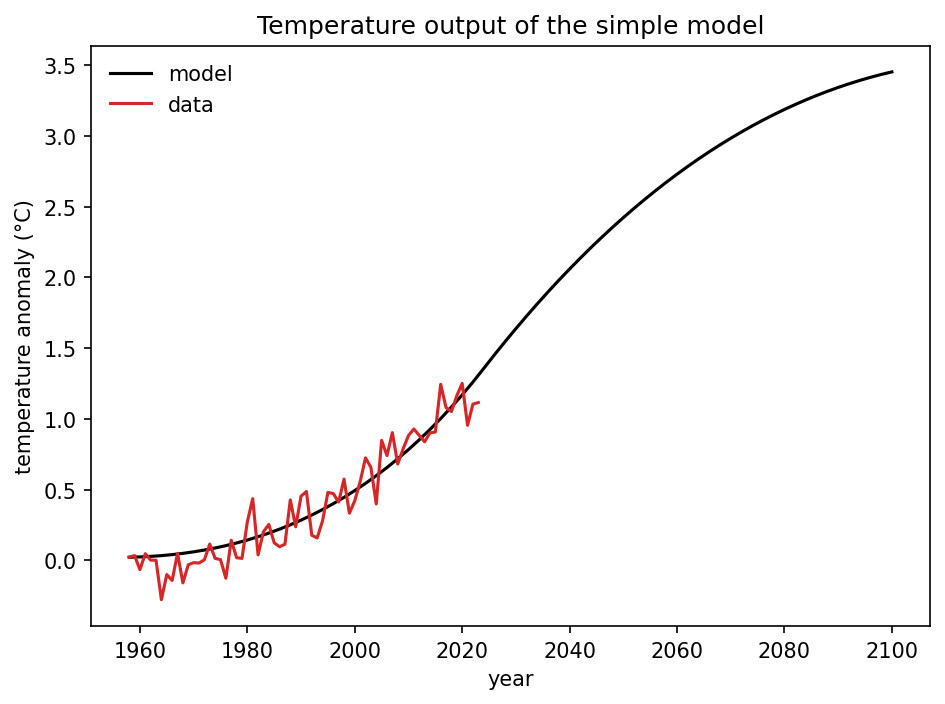

In [53]:
# solve
sol2 = ode(fun2, [arr_temp[0], arr_co2[0]], t, args = (opt2[0], opt2[1], opt2[2], opt2[3]))

# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, sol2[:,0], label = "model", color = "black")
ax.plot(years, arr_temp, label = "data", color = "tab:red")

plt.title("Temperature output of the simple model")
plt.xlabel("year")
plt.ylabel("temperature anomaly (°C)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

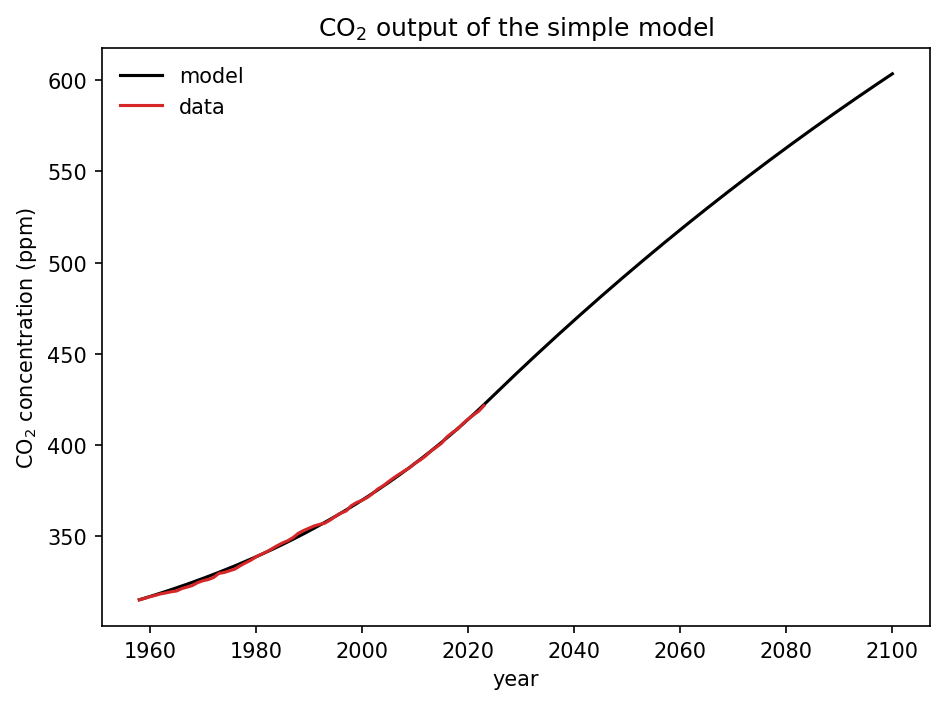

In [54]:
# plot
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)

ax.plot(t, sol2[:,1], label = "model", color = "black")
ax.plot(years, arr_co2, label = "data", color = "tab:red")

plt.title("CO$_2$ output of the simple model")
plt.xlabel("year")
plt.ylabel("CO$_2$ concentration (ppm)")
plt.legend(frameon = False)
plt.tight_layout()
plt.show()

This adjustment to the model has led to more realistic values for the temperature anomaly and CO<sub>2</sub> level by 2100, which are more aligned with [predictions from much more complex models](https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch10s10-7-2.html).


One problem with the method of fitting using least squares is that there is no easy way to find confidence intervals for the temperature anomaly and CO<sub>2</sub> levels given the model and the data. Another disadvantage is the fact that initial values must be chosen for the solutions to the ODEs. One way of avoiding this choice and having the ability to get some form of confidence intervals is to use a Bayesian statistical approach, where the prior distributions of the parameters are updated using the data, and sampling allows credible intervals to be found. 

[Stan](https://mc-stan.org/) is a probabilitstic programming language that uses Markov Chain Monte Carlo methods to sample from the posterior distributions given the available data. The final model above is implemented in RStan (the R interface to Stan), with the prior distributions for all parameters assumed to be normal with mean as the least-square estimate from above and small standard deviations. CO<sub>2</sub> and temperature anomaly is also assumed to be normal with mean given by the solution to the ODE for each year. The initial values are also assumed to be normal with mean as the first measurements available in the year 1958 and small relative standard deviations. Since prior distributions are subjective, there are no confidence intervals, but credible intervals are the Bayesian equivalent to confidence intervals. The 95% highest density interval of the sampled posterior distribution will be used as the credible intervals. 

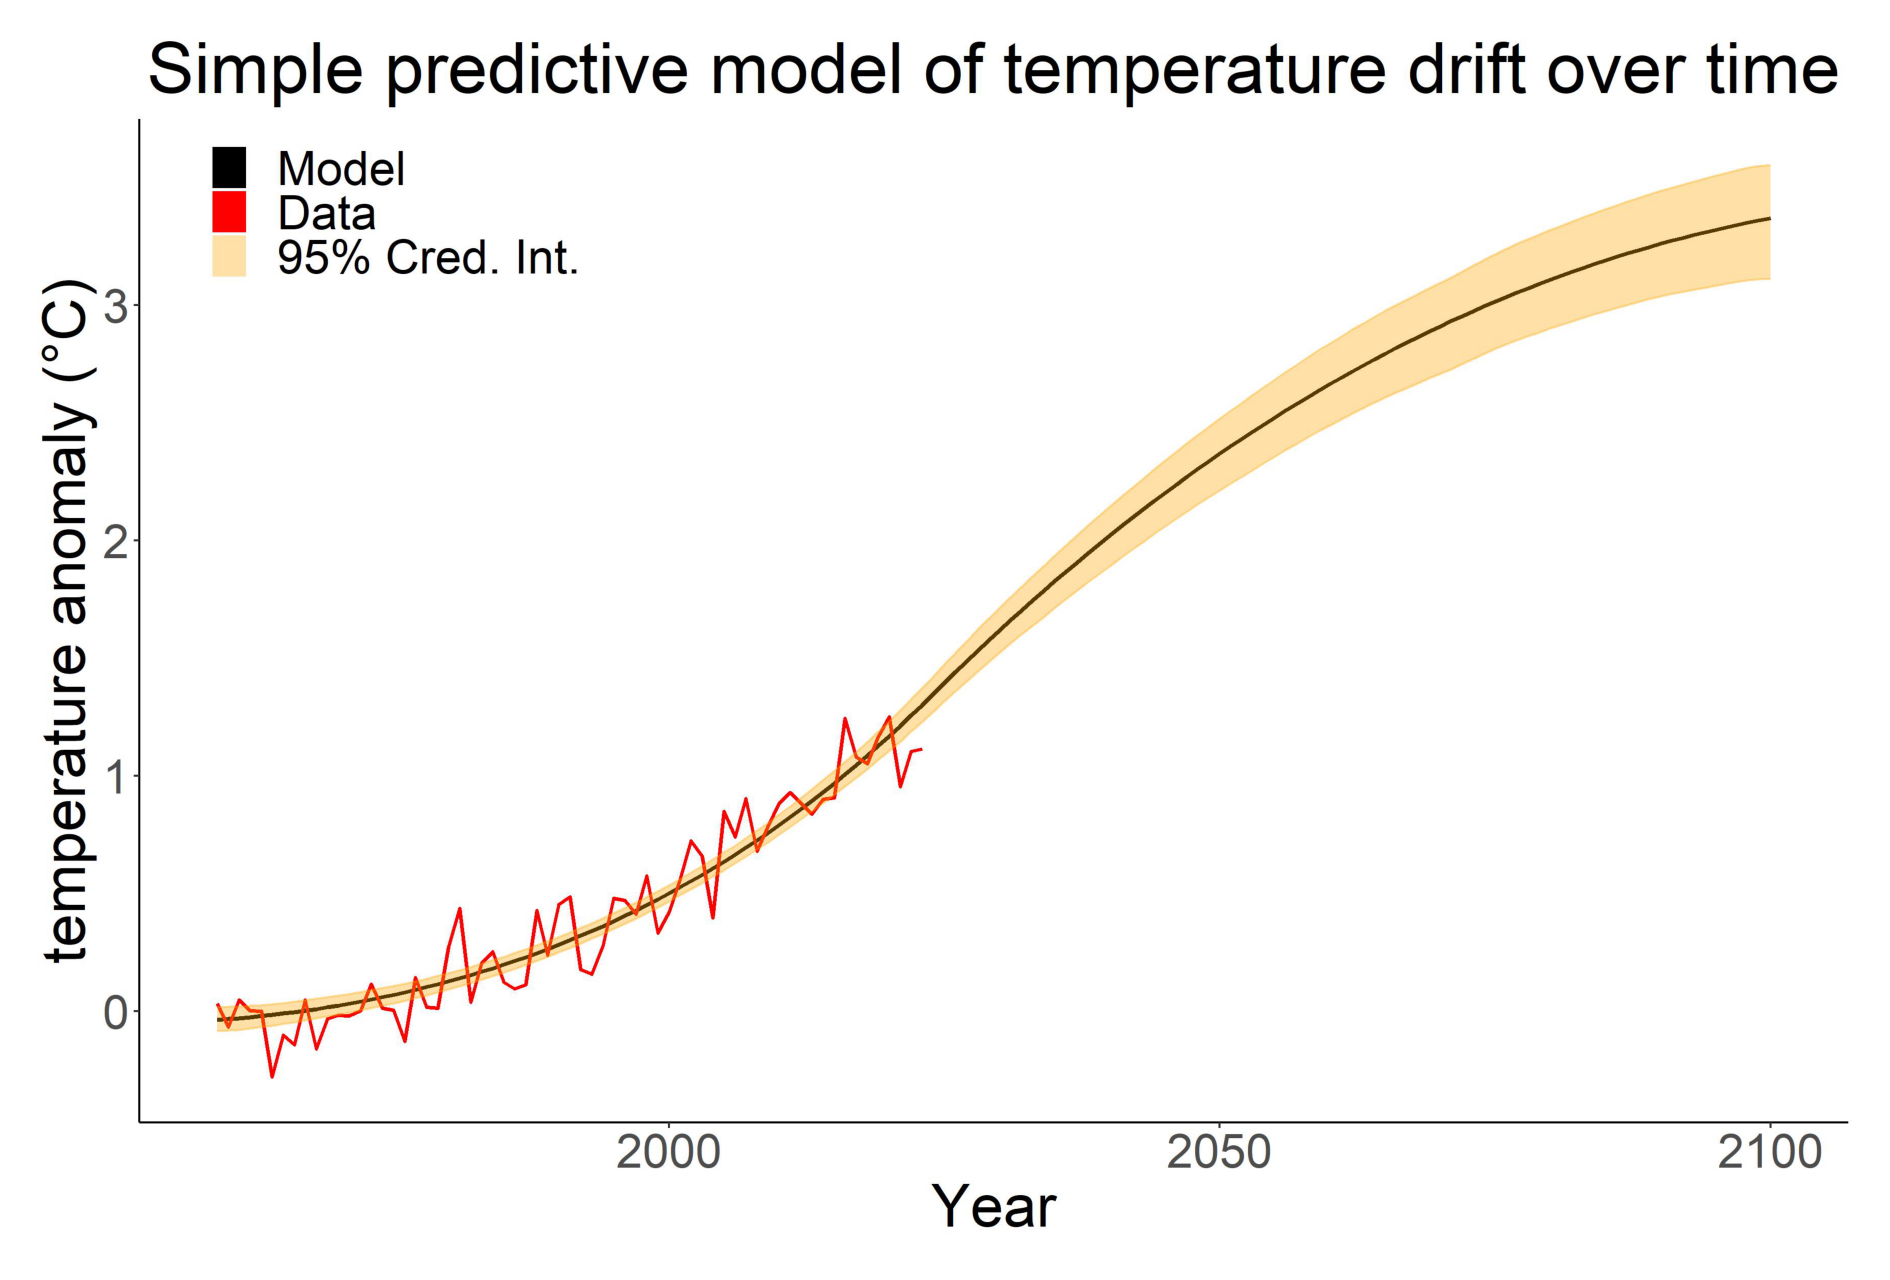

In [55]:
# show temperature anomaly plot from R

# load image
img = np.asarray(Image.open("../data/images/TempModelImage.jpg"))
# figure
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
# plot image
plt.imshow(img)
# remove axes
plt.axis('off')
plt.tight_layout()
plt.show()

Above, the temperature anomaly data is show in red, the model output is shown in black and the 95% credible interval for the model is shown in light orange.

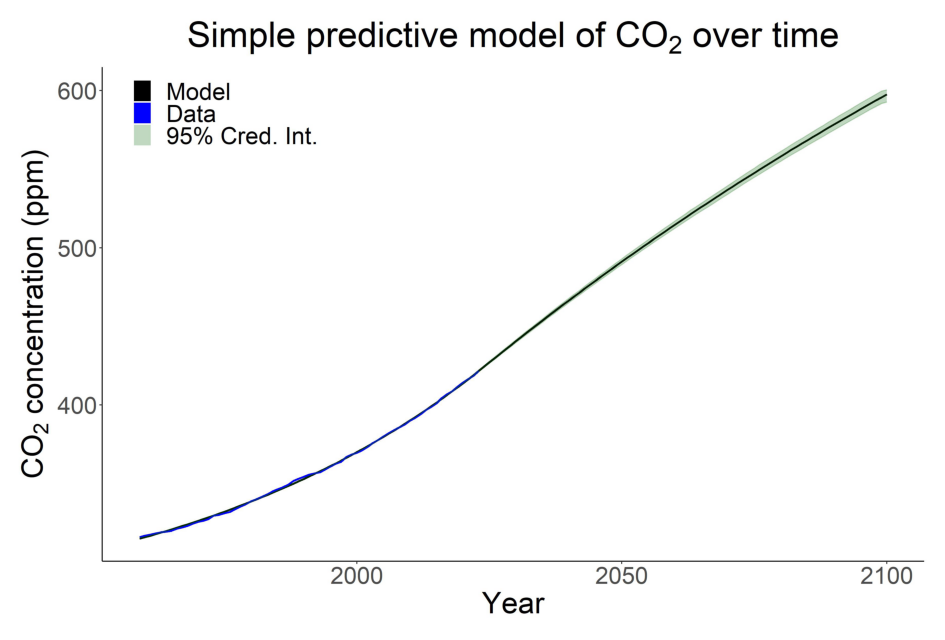

In [56]:
# show CO2 plot from R

# load image
img = np.asarray(Image.open("../data/images/CO2ModelImage.jpg"))
# figure
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
# plot image
plt.imshow(img)
# remove axes
plt.axis('off')
plt.tight_layout()
plt.show()

Above, the CO<sub>2</sub> data is shown in blue, the model is shown in black and the 95% credible interval is shown in light green.